In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style

from src import GWParameters, GWModel, save_sim_list, load_sim_list

matplotlib.style.use('seaborn-v0_8-darkgrid')
FIG_HEIGHT = 12

In [2]:
NCaRU_sim = 500

XKr = np.array([0.999503, 4.13720e-4, 7.27568e-5, 8.73984e-6, 1.36159e-6])
XKv14 = np.array([0.953060, 0.0253906, 2.53848e-4, 1.12796e-6, 1.87950e-9, 0.0151370, 0.00517622, 8.96600e-4, 8.17569e-5, 2.24032e-6])
XKv43 = np.array([0.722328, 0.101971, 0.00539932, 1.27081e-4, 1.82742e-6, 0.152769, 0.00962328, 0.00439043, 0.00195348, 0.00143629])

CaSS = np.ones((NCaRU_sim, 4)) * 1.45370e-4
CaJSR = np.ones(NCaRU_sim) * 0.908408
LCC = np.random.choice([1, 2, 7], p=[0.958, 0.038, 0.004], size=(NCaRU_sim, 4))
LCC_inactivation = np.random.choice([0, 1], p=[0.0575, 0.9425], size=(NCaRU_sim, 4))
ClCh = np.random.choice([0, 1], p=[0.998, 0.002], size=(NCaRU_sim, 4))
RyR = np.zeros((NCaRU_sim, 4, 6), dtype=np.int32)
for i in range(NCaRU_sim):
    for j in range(4):
        for k in range(5):
            idx = np.random.choice([0, 4, 5], p=[0.609, 0.5*0.391, 0.5*0.391])
            RyR[i, j, idx] += 1


init_state = {
    "V": -91.382,
    "Nai": 10.0,
    "Ki": 131.84,
    "Cai": 1.45273e-4,
    "CaNSR": 0.908882,
    "CaLTRPN": 8.9282e-3,
    "CaHTRPN": 0.137617,
    "m": 5.33837e-4,
    "h": 0.996345,
    "j": 0.997315,
    "xKs": 2.04171e-4,
    "XKr": XKr,
    "XKv14": XKv14,
    "XKv43": XKv43,

    "CaSS": CaSS,
    "CaJSR": CaJSR,
    "LCC": LCC,
    "LCC_inactivation": LCC_inactivation,
    "RyR": RyR,
    "ClCh": ClCh
}

In [3]:
NCaRU_sim = 500
#NCaRU_sim = 1250 # 10% of NCaRU = 12500
params = GWParameters(NCaRU_sim=NCaRU_sim) # Create parameters object using default values
Istim = lambda t: 35 if t < 2 else 0 # Stimulus function

model = GWModel(parameters=params, stimulus_fn=Istim, init_state=init_state) # Convenience wrapper around C++ function

In [4]:
step_size = 1e-3 # Pick a small step size for accuracy and to reduce bias from parallelising the SSA
num_steps = 700_000 # Simulate the AP for 500ms
record_every = 500 # Record the state every 500 steps (0.5 ms)

In [5]:
%%time
# model.simulate returns a gw.GWSolution object, which is basically just a wrapper around a struct of numpy arrays
sims = [model.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every) for _ in range(10)]

CPU times: user 56.3 s, sys: 25.7 s, total: 1min 22s
Wall time: 42.9 s


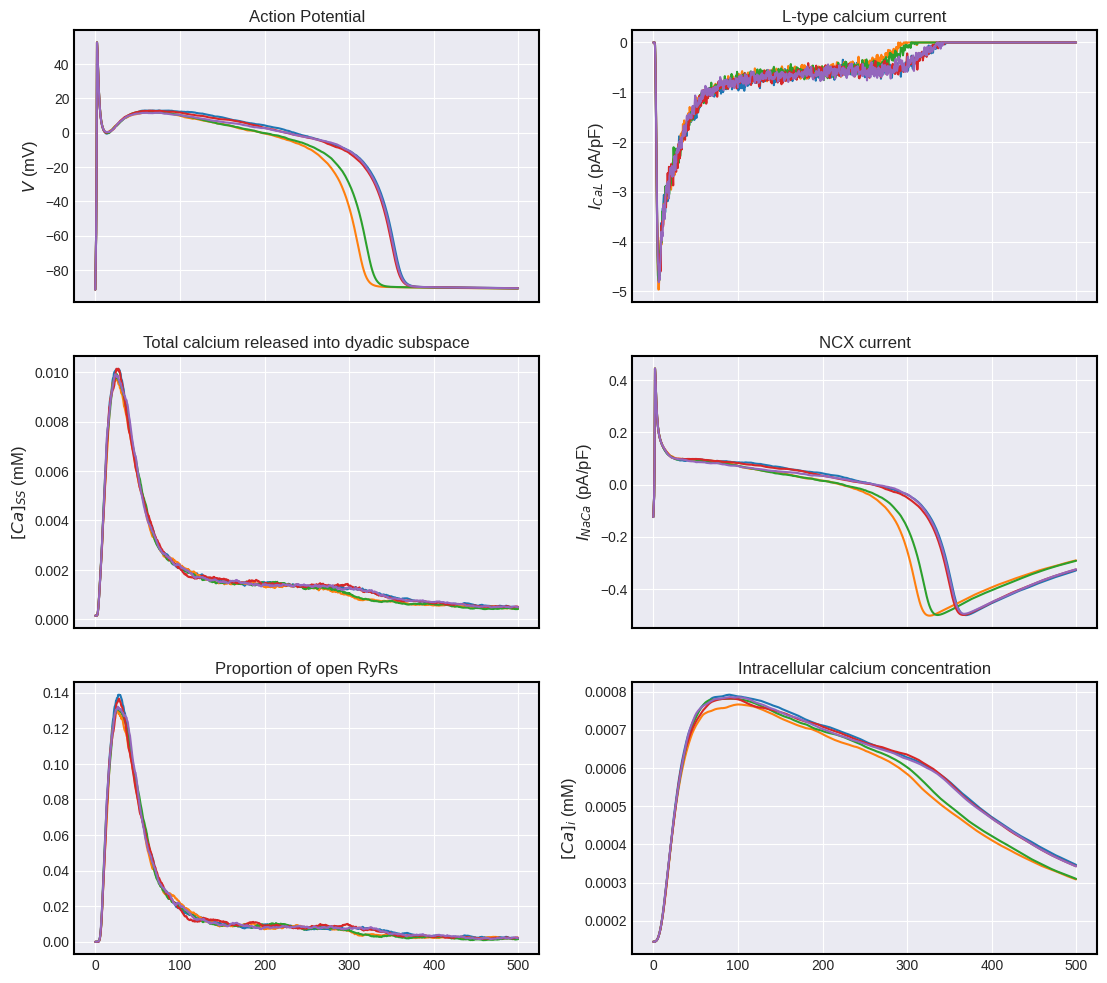

In [20]:
fig, axs = plt.subplots(3,2, figsize=(1.1*FIG_HEIGHT,FIG_HEIGHT))
for s in sims:
    axs[0,0].plot(s.t, s.V)
    axs[0,0].set_title("Action Potential", fontsize=12)
    axs[0,0].set_ylabel(r"$V$ (mV)", fontsize=12)
    axs[0,0].set_xticklabels([])

    axs[0,1].plot(s.t, s.ICaL)
    axs[0,1].set_title("L-type calcium current", fontsize=12)
    axs[0,1].set_ylabel(r"$I_{CaL}$ (pA/pF)", fontsize=12)
    axs[0,1].set_xticklabels([])

    axs[1,0].plot(s.t, s.CaSS.mean(axis=(1,2)))
    axs[1,0].set_title("Total calcium released into dyadic subspace", fontsize=12)
    axs[1,0].set_ylabel(r"$[Ca]_{SS}$ (mM)", fontsize=12)
    axs[1,0].set_xticklabels([])

    axs[1,1].plot(s.t, s.INaCa)
    axs[1,1].set_title("NCX current", fontsize=12)
    axs[1,1].set_ylabel(r"$I_{NaCa}$ (pA/pF)", fontsize=12)
    axs[1,1].set_xticklabels([])


    prop_RyR_open = (s.RyR[..., 2] + s.RyR[..., 3]) / 5 # Proportion of RyRs in open states (states 3 and 4) for single CaRU subunit
    axs[2,0].plot(s.t, prop_RyR_open.mean(axis=(1,2)))
    axs[2,0].set_title("Proportion of open RyRs", fontsize=12)

    axs[2,1].plot(s.t, s.Cai)
    axs[2,1].set_title("Intracellular calcium concentration", fontsize=12)
    axs[2,1].set_ylabel(r"$[Ca]_i$ (mM)", fontsize=12)


for ax in axs.reshape(-1):
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1.5)

plt.show()

# Effect of CaRU variance on the solutions

The model has a parameter $N_{\mathrm{CaRU}}$ (set with the `NCaRU` field of `GWParameters`), which is the number of calcium release units in a single myocyte. The default value is $N_{\mathrm{CaRU}}=12,500$, corresponding to $50,000$ subunits. Since this is computationally intensive, the model also has a parameter $N_s$ (set with the `NCaRU_sim` field of `GWParameters`) that sets the number of calcium release units to actually simulate. 

When $N_s < N_{\mathrm{CaRU}}$, the reduced number of CaRUs in the simulation is made up for by amplifying the relevant currents and fluxes ($I_{\mathrm{CaL}}$, $I_{\mathrm{to2}}$, $J_{\mathrm{xfer}}$ and $J_{\mathrm{tr}}$) by a factor of $N_{\mathrm{CaRU}} / N_{s}$. While the mean of the process should remain the same, this trick will boost the (unconditional) variance of the aforementioned currents/fluxes by a factor of $N_{\mathrm{CaRU}} / N_{s}$. Though this may not have been the intention, it is interesting for our purposes.

In [39]:
NCaRU_sim_values = [625, 1250, 2500, 6250]
params_values = [GWParameters(NCaRU_sim=NCaRU_sim) for NCaRU_sim in NCaRU_sim_values]
Istim = lambda t: 35 if t < 2 else 0 # Same as before, and same for every model

models = [GWModel(params, Istim) for params in params_values]

In [40]:
# Same as above
step_size = 1e-3 
num_steps = 500_000 
record_every = 500 

In [42]:
%%time
sims = [m.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every) for m in models]

CPU times: user 51min 50s, sys: 57.4 s, total: 52min 47s
Wall time: 3min 24s


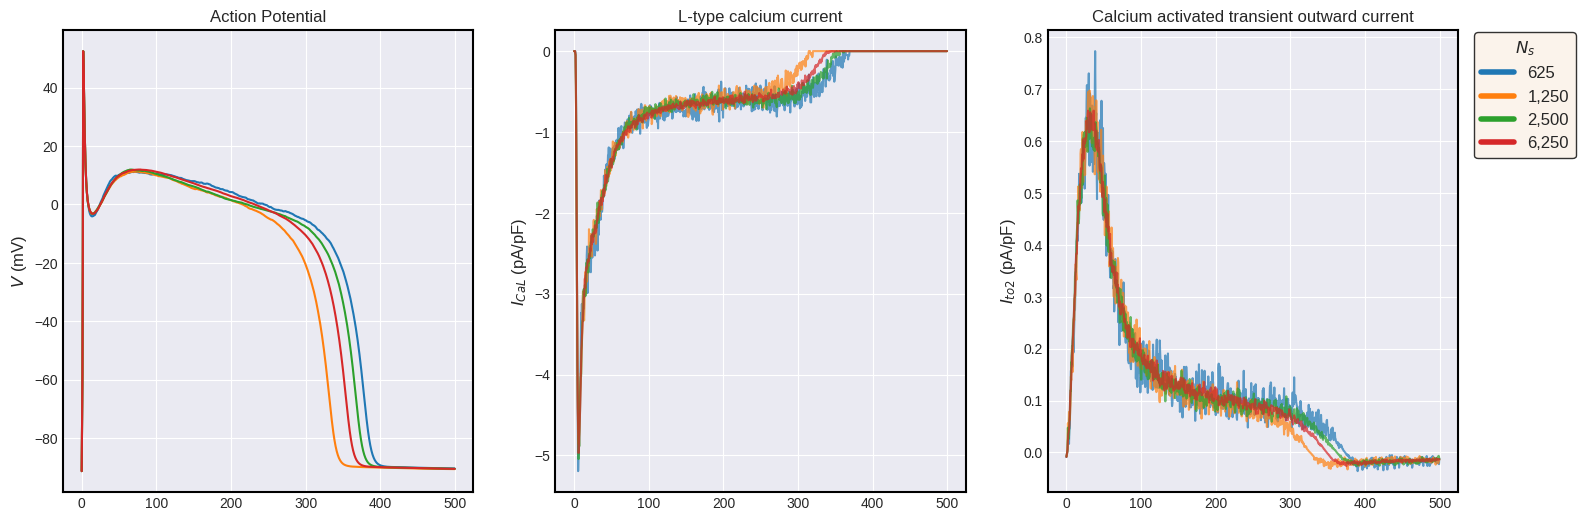

In [93]:
fig, axs = plt.subplots(1,3, figsize=(0.5*3*FIG_HEIGHT,0.5*FIG_HEIGHT))
for s, N in zip(sims, NCaRU_sim_values):
    line, = axs[0].plot(s.t, s.V, label=f"{N:,}")
    axs[0].set_title("Action Potential", fontsize=12)
    axs[0].set_ylabel(r"$V$ (mV)", fontsize=12)

    axs[1].plot(s.t, s.ICaL, alpha=0.7)
    axs[1].set_title("L-type calcium current", fontsize=12)
    axs[1].set_ylabel(r"$I_{CaL}$ (pA/pF)", fontsize=12)

    axs[2].plot(s.t, s.Ito2, alpha=0.7)
    axs[2].set_title("Calcium activated transient outward current", fontsize=12)
    axs[2].set_ylabel(r"$I_{to2}$ (pA/pF)", fontsize=12)

handles, labels = axs[0].get_legend_handles_labels()
leg = fig.legend(handles, 
           labels, 
           loc='upper right', 
           bbox_to_anchor=(.97,.89),
           title=r"$N_s$", 
           fontsize=12,
           title_fontsize=12,
           frameon=True,
           facecolor='linen',
           edgecolor='k'
           )

for line in leg.get_lines():
    line.set_linewidth(4.0)

for ax in axs.reshape(-1):
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1.5)

plt.show()

Notice that the smaller values of $N_s$ have much noisier values for the L-type calcium current and calcium activated chloride current. To explore the effect of this noise further, we look at several realisations of $N_s=250$ below.

In [122]:
params = GWParameters(NCaRU_sim=250)
model = GWModel(parameters=params, stimulus_fn=Istim)

In [ ]:
# Same as above
step_size = 1e-3 
num_steps = 500_000 
record_every = 500

In [123]:
%%time
sims = [model.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every) for _ in range(20)]

CPU times: user 46min 12s, sys: 58.5 s, total: 47min 11s
Wall time: 3min 3s


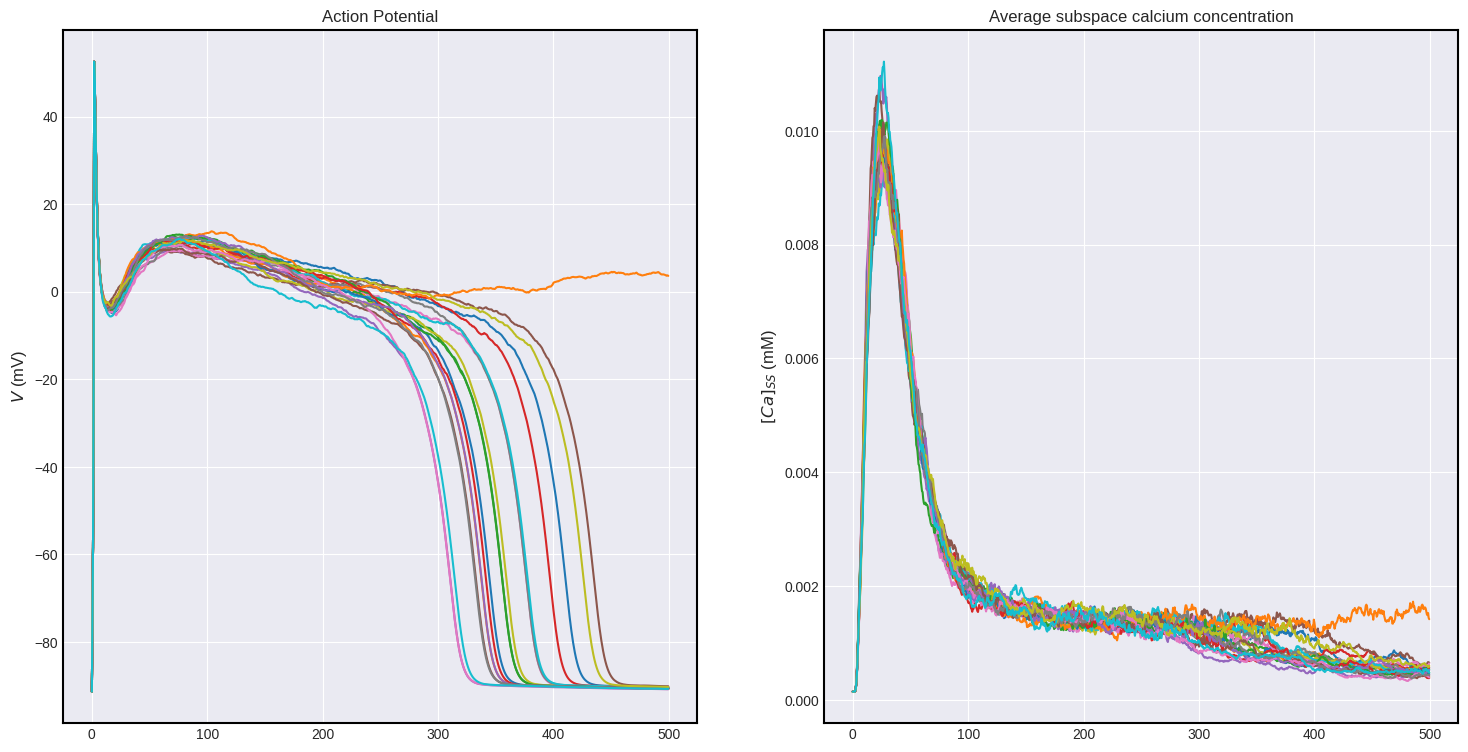

In [124]:
fig, axs = plt.subplots(1,2, figsize=(1.5*FIG_HEIGHT,1.5*0.5*FIG_HEIGHT))
for s in sims:
    axs[0].plot(s.t, s.V)
    axs[0].set_title("Action Potential", fontsize=12)
    axs[0].set_ylabel(r"$V$ (mV)", fontsize=12)

    axs[1].plot(s.t, s.CaSS.mean(axis=(1,2)))
    axs[1].set_title("Average subspace calcium concentration", fontsize=12)
    axs[1].set_ylabel(r"$[Ca]_{SS}$ (mM)", fontsize=12)

for ax in axs.reshape(-1):
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1.5)

plt.show()

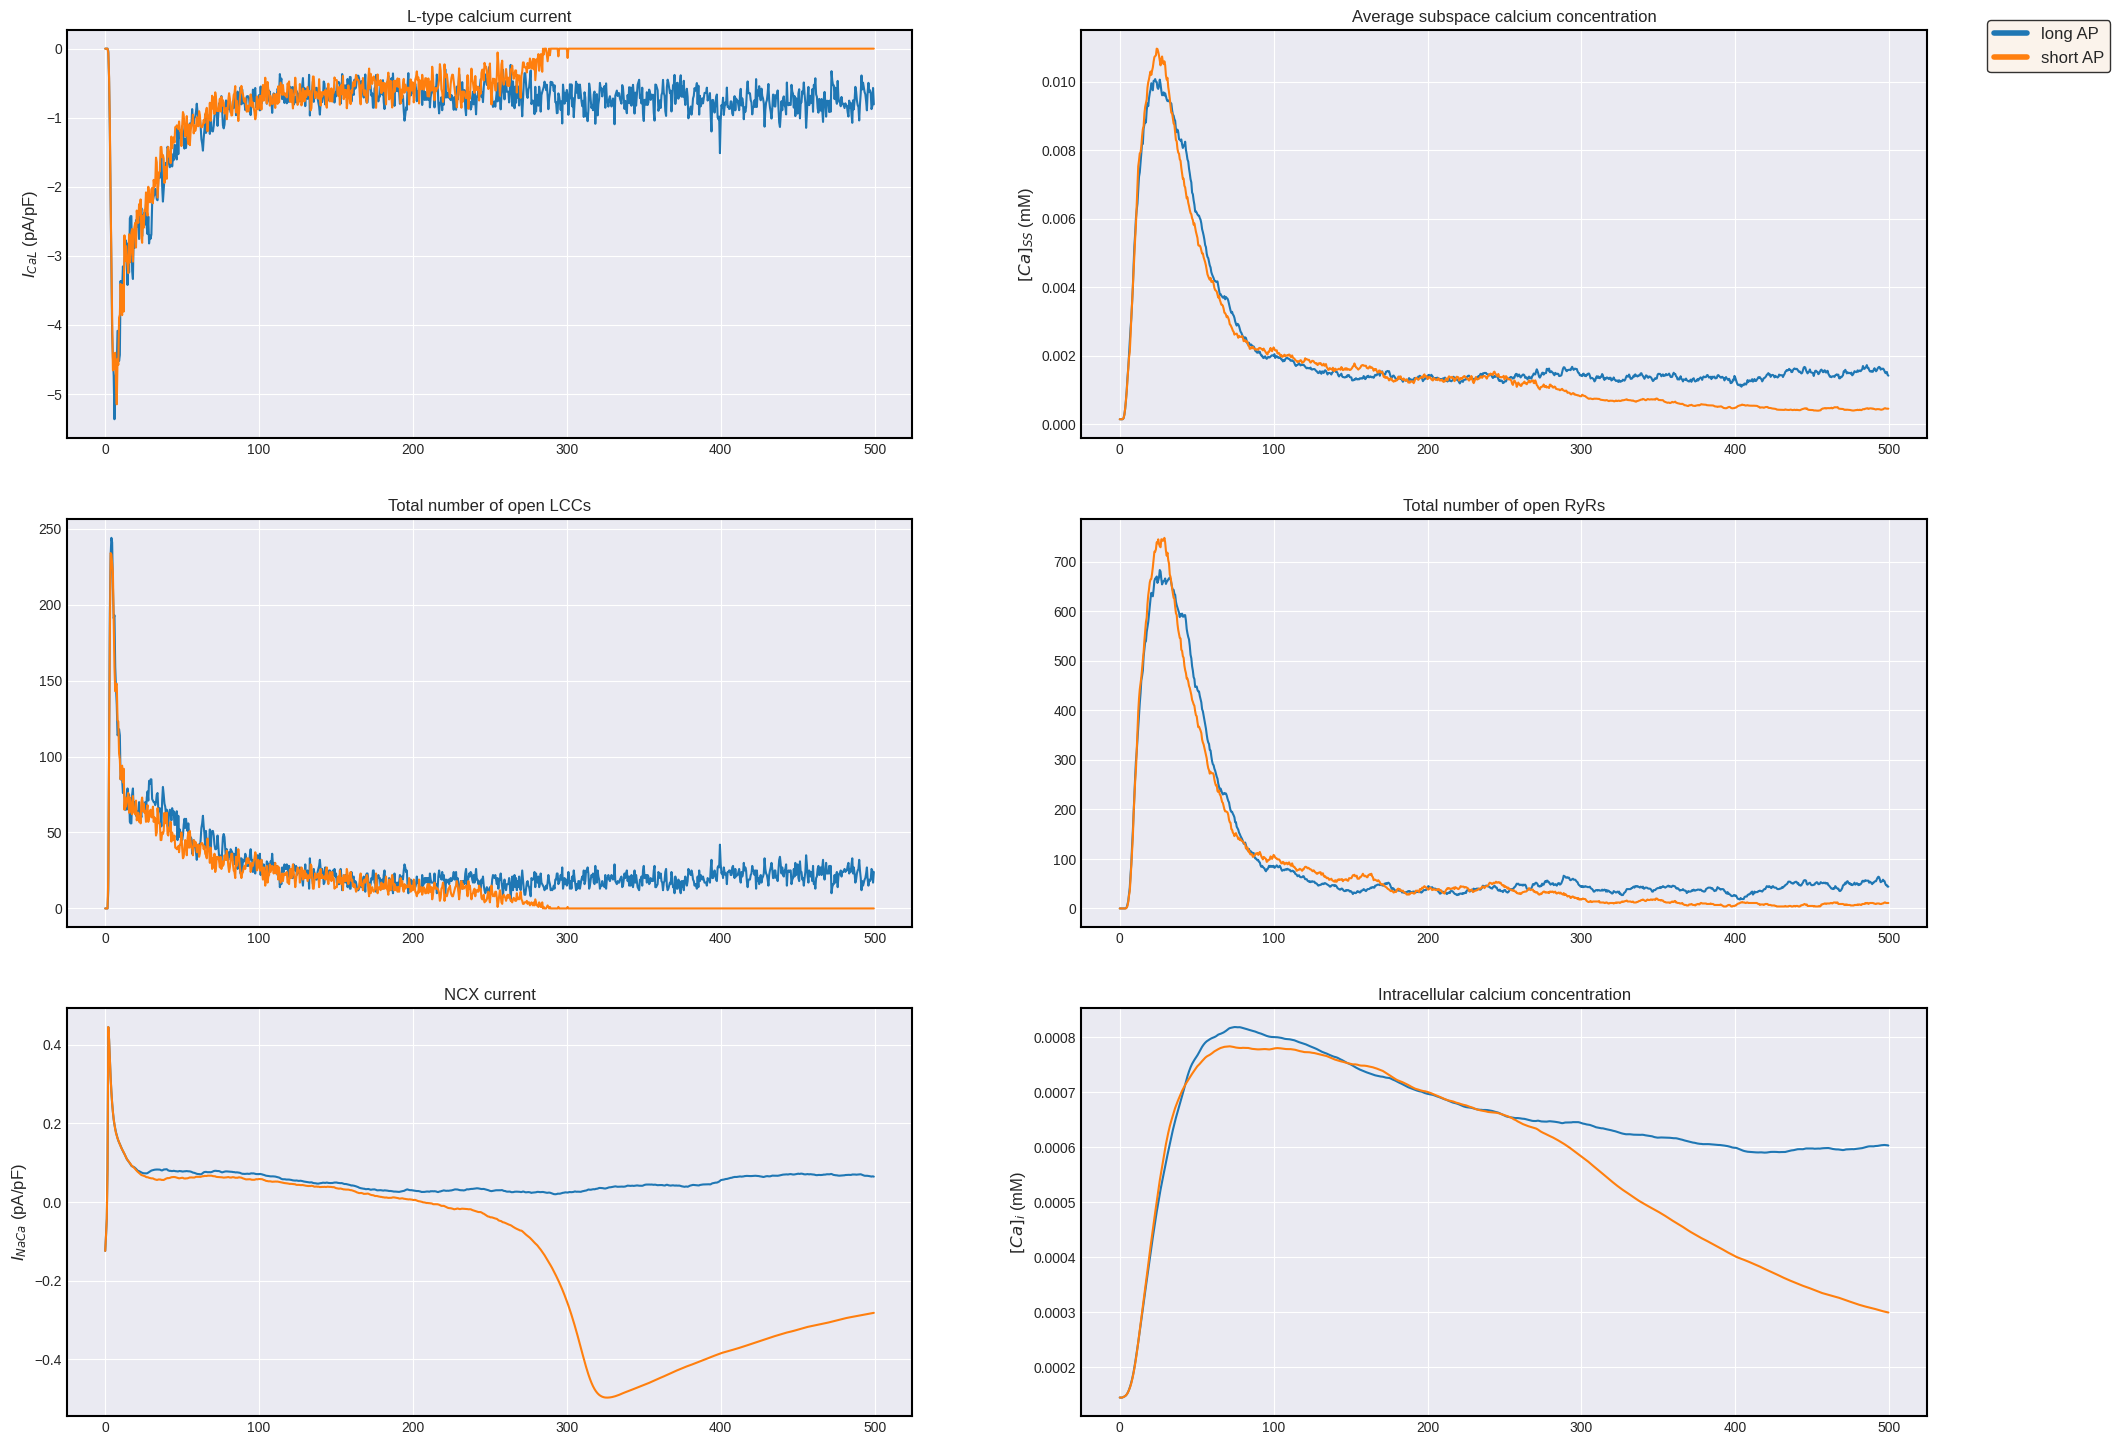

In [174]:
ap_at_400 = [s.V[800] for s in sims]
long_ap = sims[ap_at_400.index(max(ap_at_400))]
short_ap = sims[ap_at_400.index(min(ap_at_400))]

fig, axs = plt.subplots(3,2, figsize=(2*FIG_HEIGHT,1.5*FIG_HEIGHT))
axs[0,0].plot(long_ap.t, long_ap.ICaL, label="long AP")
axs[0,0].plot(short_ap.t, short_ap.ICaL, label="short AP")
axs[0,0].set_title("L-type calcium current", fontsize=12)
axs[0,0].set_ylabel(r"$I_{CaL}$ (pA/pF)", fontsize=12)

axs[0,1].plot(long_ap.t, long_ap.CaSS.mean(axis=(1,2)))
axs[0,1].plot(short_ap.t, short_ap.CaSS.mean(axis=(1,2)))
axs[0,1].set_title("Average subspace calcium concentration", fontsize=12)
axs[0,1].set_ylabel(r"$[Ca]_{SS}$ (mM)", fontsize=12)

long_ap_open_LCC = ((long_ap.LCC == 6) | (long_ap.LCC == 12)) & (long_ap.LCC_inactivation == 1)
short_ap_open_LCC = ((short_ap.LCC == 6) | (short_ap.LCC == 12)) & (short_ap.LCC_inactivation == 1)
axs[1,0].plot(long_ap.t, long_ap_open_LCC.sum(axis=(1,2)))
axs[1,0].plot(short_ap.t, short_ap_open_LCC.sum(axis=(1,2)))
axs[1,0].set_title("Total number of open LCCs", fontsize=12)

long_ap_open_RyR = long_ap.RyR[..., 2] + long_ap.RyR[..., 3]
short_ap_open_RyR = short_ap.RyR[..., 2] + short_ap.RyR[..., 3]
axs[1,1].plot(long_ap.t, long_ap_open_RyR.sum(axis=(1,2)))
axs[1,1].plot(short_ap.t, short_ap_open_RyR.sum(axis=(1,2)))
axs[1,1].set_title("Total number of open RyRs", fontsize=12)

axs[2,0].plot(long_ap.t, long_ap.INaCa, label="long AP")
axs[2,0].plot(short_ap.t, short_ap.INaCa, label="short AP")
axs[2,0].set_title("NCX current", fontsize=12)
axs[2,0].set_ylabel(r"$I_{NaCa}$ (pA/pF)", fontsize=12)

axs[2,1].plot(long_ap.t, long_ap.Cai)
axs[2,1].plot(short_ap.t, short_ap.Cai)
axs[2,1].set_title("Intracellular calcium concentration", fontsize=12)
axs[2,1].set_ylabel(r"$[Ca]_{i}$ (mM)", fontsize=12)

handles, labels = axs[0,0].get_legend_handles_labels()
leg = fig.legend(handles, 
           labels, 
           loc='upper right', 
           bbox_to_anchor=(.98,.89),
           fontsize=12,
           frameon=True,
           facecolor='linen',
           edgecolor='k'
           )

for line in leg.get_lines():
    line.set_linewidth(4.0)


for ax in axs.reshape(-1):
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1.5)

plt.show()

# Effect of increasing LCC open time

We will go back to the default number of $N_s = 1,250$ and consider the effect of increasing the mean amount of time an LCC spends in the open state. 
This can be done by changing the parameter `g` in `gw.GWParameters`, which is the rate at which an LCC in the open state 6 transitions to the closed state 5 (only accessible state from 6). By decreasing this rate, the mean amount of time an LCC remains open increases, which will amplify the L-type calcium current. 

In [188]:
NCaRU_sim = 1250 
default_g = GWParameters().g
print(f"Default value of g: {default_g}")
params = GWParameters(NCaRU_sim=NCaRU_sim, g=0.9*default_g)
print(f"New value of g: {params.g}")
Istim = lambda t: 35 if t < 2 else 0 # Stimulus function

model = GWModel(parameters=params, stimulus_fn=Istim) # Convenience wrapper around C++ function

Default value of g: 2.0
New value of g: 1.8


In [189]:
step_size = 1e-3 
num_steps = 600_000 
record_every = 500 

In [190]:
%%time
sims = [model.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every) for _ in range(5)]

CPU times: user 39min 46s, sys: 49.2 s, total: 40min 35s
Wall time: 2min 37s


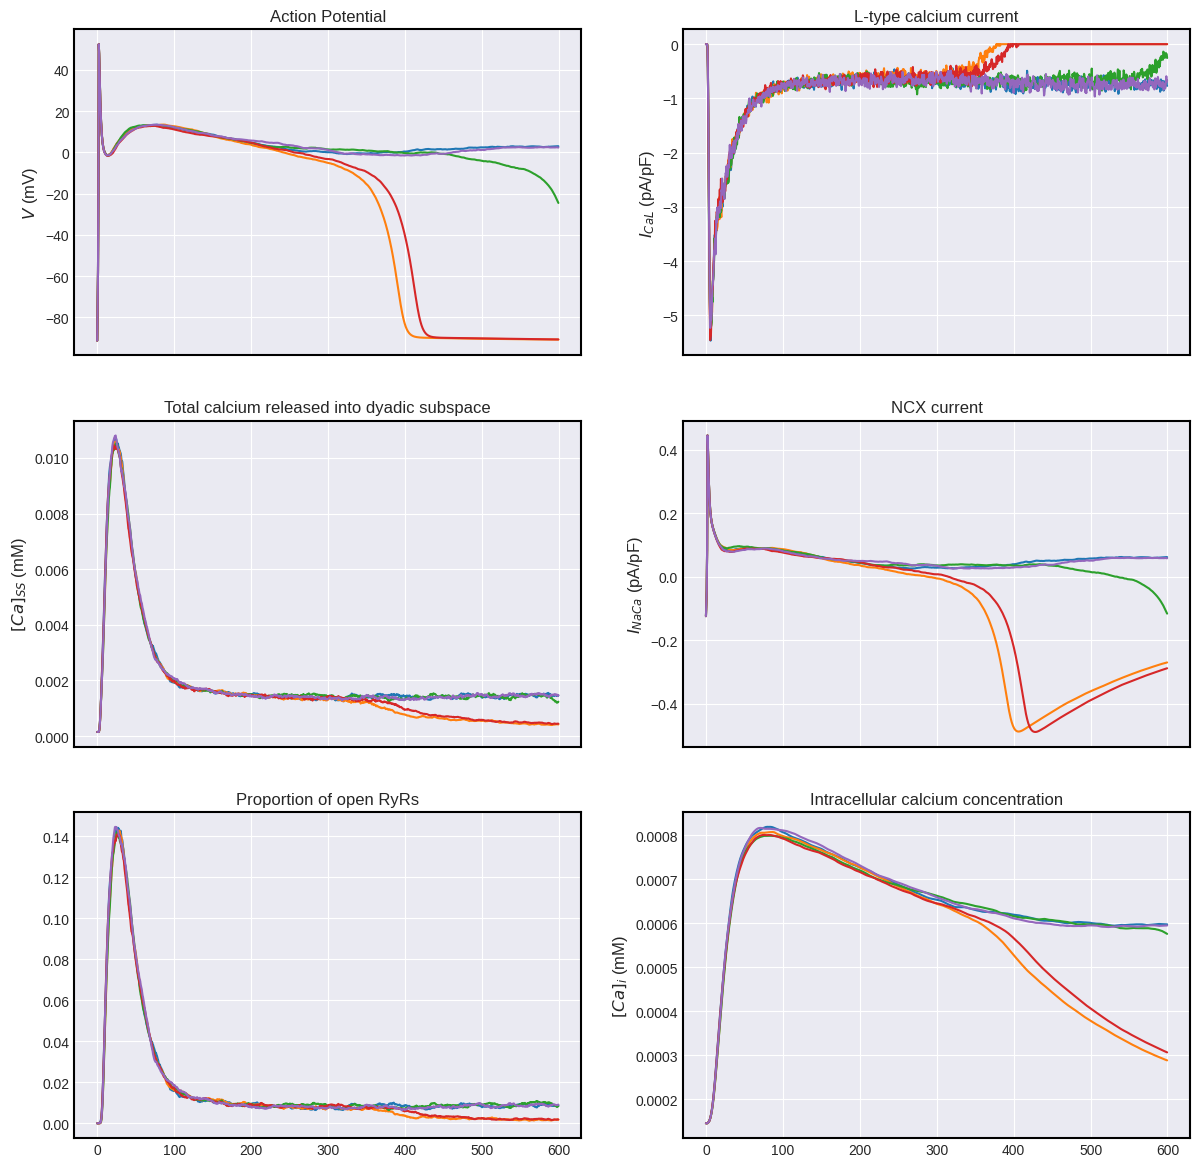

In [194]:
fig, axs = plt.subplots(3,2, figsize=(1.2*FIG_HEIGHT,1.2*FIG_HEIGHT))
for s in sims:
    axs[0,0].plot(s.t, s.V)
    axs[0,0].set_title("Action Potential", fontsize=12)
    axs[0,0].set_ylabel(r"$V$ (mV)", fontsize=12)
    axs[0,0].set_xticklabels([])

    axs[0,1].plot(s.t, s.ICaL)
    axs[0,1].set_title("L-type calcium current", fontsize=12)
    axs[0,1].set_ylabel(r"$I_{CaL}$ (pA/pF)", fontsize=12)
    axs[0,1].set_xticklabels([])

    axs[1,0].plot(s.t, s.CaSS.mean(axis=(1,2)))
    axs[1,0].set_title("Total calcium released into dyadic subspace", fontsize=12)
    axs[1,0].set_ylabel(r"$[Ca]_{SS}$ (mM)", fontsize=12)
    axs[1,0].set_xticklabels([])

    axs[1,1].plot(s.t, s.INaCa)
    axs[1,1].set_title("NCX current", fontsize=12)
    axs[1,1].set_ylabel(r"$I_{NaCa}$ (pA/pF)", fontsize=12)
    axs[1,1].set_xticklabels([])


    prop_RyR_open = (s.RyR[..., 2] + s.RyR[..., 3]) / 5 # Proportion of RyRs in open states (states 3 and 4) for single CaRU subunit
    axs[2,0].plot(s.t, prop_RyR_open.mean(axis=(1,2)))
    axs[2,0].set_title("Proportion of open RyRs", fontsize=12)

    axs[2,1].plot(s.t, s.Cai)
    axs[2,1].set_title("Intracellular calcium concentration", fontsize=12)
    axs[2,1].set_ylabel(r"$[Ca]_i$ (mM)", fontsize=12)


for ax in axs.reshape(-1):
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1.5)

plt.show()